In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

In [11]:
##Going to use the log regress code for the actual model
def read_dataset(feature_file, label_file):
    ''' Read data set in *.csv to data frame in Pandas'''
    df_X = pd.read_csv(feature_file)
    df_y = pd.read_csv(label_file)
    X = df_X.values # convert values in dataframe to numpy array (features)
    y = df_y.values # convert values in dataframe to numpy array (label)
    return X, y

def get_mean_variance(X):
    mean = np.mean(X, axis=0) # axis=0: taking means along the
    # vertical line (column)
    # (sum(x_i-\mu)^2)/N
    X_temp = X - mean #
    X_temp_entrypointwise = X_temp*X_temp
    variance = np.mean(X_temp_entrypointwise, axis=0) #axis=0: 
    # taking means along the vertical line (column)
    return mean, variance
    
def normalize_features(X_train, X_test):
    mean, variance = get_mean_variance(X_train)
    variance += 1e-15
    ''' transform the feature '''
    X_train_norm = (X_train - mean)/np.sqrt(variance)
    #math.sqrt doesnot work for numpy
    X_test_norm = (X_test - mean)/np.sqrt(variance)
    return X_train_norm, X_test_norm

def add_column_one(X):
    '''
         convert X -> [1 X]
    '''
    # add  column of ones
    ones = np.ones(X.shape[0])
    ones = ones.reshape(-1, 1)
    X_new = np.append(ones, X, axis=1)

    return X_new

def predictor(X, c):
    ''' sigmoid function '''
    return 1.0/(1.0 + np.exp(-X.dot(c)))

def loss(y_exact, y_pred):
    return (-y_exact.T.dot(np.log(y_pred+1e-15))- (1.0 - y_exact).T.dot(np.log(1-y_pred+1e-15)))/float(len(y_exact))

def gradient_descent(X, y, epochs=1000, learning_rate=0.0001):
    '''
        Input
        -----
        X: training features (normalized and having bias)
        y: labels
        
        output
        ------
        c: optimal coeffs
        loss_history
    '''
    loss_history = [0]*epochs
    c_dim = X.shape[1]
    n_samples = X.shape[0]
    c = np.ones((c_dim, 1))
    print(y.shape)
    for epoch in range(epochs):
        y_pred = predictor(X, c)
        
        loss_history[epoch] = loss(y_pred, y).ravel()[0] # (2D) (1,1) -> 1D
                                                               # [5] -> 5
       
        XT = X.T
        gradient = XT.dot(y_pred-y)/float(n_samples)   
        # updating coeffs upon the gradient change
        c = c - learning_rate*gradient
    return c, loss_history

def one_hot_encoder(y_train, y_test):
    ''' convert label to a vector under one-hot-code fashion '''
    from sklearn import preprocessing
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    y_train_ohe = lb.transform(y_train)
    y_test_ohe = lb.transform(y_test)
    return y_train_ohe, y_test_ohe

def multilabel_train(X, y):# y_train: one_hot_encoder labels
    # y_train will have 3 columns
    c_list = []
    for i in range(y.shape[1]): # 3 columns 
        y_one_column = y[:, i].reshape(-1, 1) # pick ith columns
        c_one_column, loss_history = gradient_descent(X, y_one_column, epochs=10000, learning_rate=0.9)
        #plot_loss(loss_history)
        c_list.append(c_one_column)
    return c_list


def multilabel_prediction(c_list, X):
    i = 0
    for c in c_list:
        probability = predictor(X, c)
        # probabily of one column
        if i == 0:
            probability_matrix = probability
        else:
            # combine all decision columns to form a matrix
            probability_matrix = np.concatenate(
                              (probability_matrix, probability),
                               axis=1)
        i += 1
    labels = [0, 1, 2]
    n_samples = X.shape[0]
    # find which index gives us the highest probability
    y_pred = np.zeros(n_samples, dtype=int) 
    for i in range(n_samples):
        y_pred[i] = labels[np.argmax(probability_matrix[i,:])]
    return y_pred, probability_matrix

def label_out(y_pre, threshold=.5): 
    label = np.copy(y_pre)
    label[label>threshold ] = 1
    label[label<threshold] = 0 
    return label.astype(int)

In [12]:
pwd = './homework/data/HW2_data/HW2_data/'
X_train, y_train = read_dataset(pwd+'X_iris_train.csv', pwd+'y_iris_train.csv')
X_test, y_test = read_dataset(pwd+'X_iris_test.csv',pwd+'y_iris_test.csv')
X_train_norm, X_test_norm = normalize_features(X_train, X_test)
X_train_norm_new = add_column_one(X_train_norm)
X_test_norm_new = add_column_one(X_test_norm)

y_train_ohe, y_test_ohe = one_hot_encoder(y_train, y_test)
c_list = multilabel_train(X_train_norm_new, y_train_ohe)

y_pred,prob_matrix = multilabel_prediction(c_list, X_test_norm_new)

(112, 1)
(112, 1)
(112, 1)


In [64]:
##All the metric stuff 

def get_con_matrix(score, true_label): 
    '''True: OHE test values 
    score: score predicted by the sigmoid 
    
    returns the list of rates across a confusion matrix
    ''' 
    ##Go through threshold on range of 0 to 1 
    ##Compare predicted to true values for each threshold 
        ##Get TP, FP, FN, TN
    TNR_lst = []
    FPR_lst = []
    FNR_lst = []
    TPR_lst = []
    for i in range(101,-1,-1): 
        thresh = i/100    
        ##Compare predicted to true values for each threshold 
        pre_label = label_out(score, thresh)
        tn = np.sum(np.logical_and(pre_label == 0, true_label == 0))
        tp = np.sum(np.logical_and(pre_label == 1, true_label == 1))
        fp = np.sum(np.logical_and(pre_label == 1, true_label == 0))
        fn = np.sum(np.logical_and(pre_label == 0, true_label == 1))

        TNR_lst.append(tn/(tn+fp))
        FPR_lst.append(fp/(tn+fp))
        FNR_lst.append(fn/(fn+tp))
        TPR_lst.append(tp/(fn+tp))
    return TNR_lst,FPR_lst,FNR_lst,TPR_lst

def ROC_stair(FPR_lst,TPR_lst):
    '''Give a staircase plot ver
    '''
    FPR_roc = []
    TPR_roc = []
    for i in range(len(FPR_lst)-1):
        FPR_roc.append(FPR_lst[i])
        TPR_roc.append(TPR_lst[i])
        FPR_roc.append(FPR_lst[i+1])
        TPR_roc.append(TPR_lst[i])
    return FPR_roc, TPR_roc


def ROC_plot(FPR_lst,FNR_lst):
    plt.plot(FPR_lst,FNR_lst, color = 'g')
    plt.plot([0,1],[0,1], color = 'navy', linestyle = '--')
    plt.xlim([0,1.01])
    plt.ylim([0,1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel("False Negative Rate")
    plt.show


def AUC(fpr_roc, tpr_roc):
    a = 0 
    for i in range(len(fpr_roc)-1):
        a += tpr_roc[i]*(fpr_roc[i+1]-fpr_roc[i])
    return a

0.9043478260869565


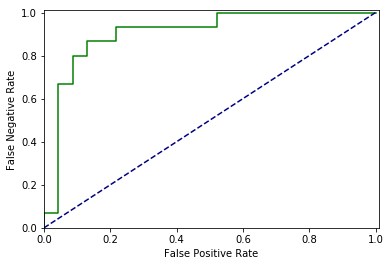

In [65]:
tnr,fpr,fnr,tpr = get_con_matrix(prob_matrix[:,1],y_test_ohe[:,1])
fpr_s,tpr_s = ROC_stair(fpr,tpr)
auc = AUC(fpr_s,tpr_s)
ROC_plot(fpr_s,tpr_s)
print(AUC(fpr_s,tpr_s))

In [ ]:
def macro_auc(prob_matrix, true_label):
    '''AUC for all the labels combined 
    '''
    return ""